# Generative Adversarial Network in TensorFlow

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
'''
An example of distribution approximation using Generative Adversarial Networks in TensorFlow.
Based on the blog post by Eric Jang: http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html,
and of course the original GAN paper by Ian Goodfellow et. al.: https://arxiv.org/abs/1406.2661.
The minibatch discrimination technique is taken from Tim Salimans et. al.: https://arxiv.org/abs/1606.03498.
'''
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)

#This generates N random points that have nothing to do with the actual distribution. 
#The only restriction is that they be in some range (that we specify as -8 to 8 in the toy example )
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        #np.lin space(-8 to 8, N)   generates N even divisions of -8 to 8.  
        # np.random.random(N) * .01  generates  N random samples between 
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

#creates linear combination of the input samples: 
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

# linear combination of inputs, then softmax that, then linear combo that: 
def generator(input, h_dim):
    h0 = tf.nn.softplus(linear(input, h_dim, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1


#needs more layers to be more powerful than the generator 
#see below for what the outut looks like. Output shape is batch_size x 1.
def discriminator(input, h_dim, minibatch_layer=True):
    h0 = tf.tanh(linear(input, h_dim * 2, 'd0'))
    h1 = tf.tanh(linear(h0, h_dim * 2, 'd1'))

    # without the minibatch layer, the discriminator needs an additional layer
    # to have enough capacity to separate the two distributions correctly
    if minibatch_layer:
        h2 = minibatch(h1)
    else:
        h2 = tf.tanh(linear(h1, h_dim * 2, scope='d2'))

    h3 = tf.sigmoid(linear(h2, 1, scope='d3'))

    #outputs a probability that the data is real:
    return h3


def minibatch(input, num_kernels=5, kernel_dim=3):
    x = linear(input, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    return tf.concat([input, minibatch_features],1)

#Standard gradient descent function that's minimizing MSE with an adaptive learning rate. 
# It updates the parameters of the neural net in the direction of the gradient so as to minimize the loss.
def optimizer(loss, var_list, initial_learning_rate):
    decay = 0.95
    num_decay_steps = 150
    batch = tf.Variable(0)

    # This lowsers the learning rate as the training continues so as to get more nuanced. 
    # Don't want a small step size at the beginning because gradient descent can take forever to converge. 
    # You don't want a large step size in the end because it might jump over the minimum 
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )

    #Changed this to Adam from GradientDescentOptimizer because it performs better according to ....
    # https://github.com/soumith/ganhacks#how-to-train-a-gan-tips-and-tricks-to-make-gans-work
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=batch, var_list=var_list)
    
    return optimizer


class GAN(object):
    def __init__(self, data, gen, num_steps, batch_size, minibatch, log_every, mlp_hidden_size, anim_path):
        self.data = data
        self.gen = gen
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.minibatch = minibatch
        self.log_every = log_every
        self.mlp_hidden_size = mlp_hidden_size
        self.anim_path = anim_path
        self.anim_frames = []

        # can use a higher learning rate when not using the minibatch layer
        self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
        if self.minibatch:
            self.learning_rate = 0.005
        else:
            self.learning_rate = 0.03

        self._create_model()

    def _create_model(self):
        # In order to make sure that the discriminator is providing useful gradient
        # information to the generator from the start, we're going to pretrain the
        # discriminator using a maximum likelihood objective. We define the network
        # for this pretraining step scoped as D_pre. The variable_scope thing means that 
        # variables in this block will be named "D_pre" and it shares variables with other blocks. 

        with tf.variable_scope('D_pre'):
            #initialize variables with their sizes: 
            # (defined explicitly in pre-training section of def(train)  )
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))

            #takes the 12 random values & applies several non-linear function layers. 
            #Output is 12x1 array 
            D_pre = discriminator(self.pre_input, self.mlp_hidden_size, self.minibatch)

            #The mean squared error between the output of the discriminator & the likelihood from the 12 random numbers. 
            #Large loss on the first iteration cuz it's basically random. 
            self.pre_loss = tf.reduce_mean(tf.square(D_pre - self.pre_labels))

            #optimize the first time: 
            self.pre_opt = optimizer(self.pre_loss, None, self.learning_rate)

        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('Gen'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = generator(self.z, self.mlp_hidden_size)

        # The discriminator tries to tell the difference between samples from the
        # true data distribution (self.x) and the generated samples (self.z).
        #
        # Here we create two copies of the discriminator network (that share parameters),
        # as you cannot use the same network with different inputs in TensorFlow.
        with tf.variable_scope('Disc') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))   
            #x is sampled from the real distribution (ie gaussian )
            #G is output by the generator

            self.D1 = discriminator(self.x, self.mlp_hidden_size, self.minibatch)
            scope.reuse_variables()
            self.D2 = discriminator(self.G, self.mlp_hidden_size, self.minibatch)

        # Define the loss for discriminator and generator networks (see the original
        # paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1 - self.D2))   
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))

        #initalize storage for the optimized parameters:
        self.d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
        self.d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
        self.g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')

        #this either stores the gradients or an operation that can be used to apply the gradients
        self.opt_d = optimizer(self.loss_d, self.d_params, self.learning_rate)
        self.opt_g = optimizer(self.loss_g, self.g_params, self.learning_rate)

    def train(self):
        
        # Starting a session puts the tensors we'll create somewhere (CPU or GPU): 
        with tf.Session() as session:
            #initialize all variables at one time: 
            tf.global_variables_initializer().run()      

            # pre-training discriminator: 
            num_pretrain_steps = 1000
            for step in range(num_pretrain_steps):
                #d generates batch_size random numbers between -5 and 5: 
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                #labels generates the likelihood of seeing those above values from a distribution with mean mu and std sigma: 
                labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
                
                #this session.run() says to return the value of 2 operations, pre_loss and pre_opt
                # the pre_loss and pre_opt operations need pre_input and pre_labels to run 
                # those were initialized in _create_model but they're defined here in the dictionary... 
                pretrain_loss, _ = session.run([self.pre_loss, self.pre_opt],                          
                    {self.pre_input: np.reshape(d, (self.batch_size, 1)),     #the rando numbers between -5 and 5 (turns the list into a np array)
                    self.pre_labels: np.reshape(labels, (self.batch_size, 1))  #the likelihood/pdf from those numbers
                })
                #Look at the _create_model function to see how pre_loss and pre_opt run now
            
            #run the d_pre_params operation, which runs all the stuff in D_pre scope. 
            # Still using d as pre_input and labels as pre_labels? 
            #returns pre_loss optimized 
            self.weightsD = session.run(self.d_pre_params)
            
            # copy weights from pre-training over to new D network
            for i, v in enumerate(self.d_params):
                session.run(v.assign(self.weightsD[i]))
                
            loss_d_list = []
            loss_g_list = []
            
            for step in range(self.num_steps):   #num_steps = 1200 in the base toy example 
                # --- update discriminator ---
                
                # x = 12 samples from the normal distribution mu = 4, sig = .5  : 
                x = self.data.sample(self.batch_size) 
                # z = 12 random points between -8 and 8 with some noise: 
                z = self.gen.sample(self.batch_size) 
                
                # calculate the loss between the real data and the random data, then the optimizer finds the paramters 
                # to reduce loss of the discriminator this round. 
                loss_d, _ = session.run([self.loss_d, self.opt_d], {
                    self.x: np.reshape(x, (self.batch_size, 1)),
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                
                # ----  update generator ------
                #generate a new 12 random points between -8 and 8 with some noise: 
                z = self.gen.sample(self.batch_size)
                
                # calculate the loss between ____ , then the optimizer finds the paramters 
                # to reduce loss of the generator this round. 
                loss_g, _ = session.run([self.loss_g, self.opt_g], {
                    self.z: np.reshape(z, (self.batch_size, 1))
                })
                

                #outputs step_number, discriminator's loss, generator's loss 
                # goal is for discriminator to have higher loss over time and generator to have lower loss. 
                if step % self.log_every == 0:
                    #print('{}: {}\t{}'.format(step, loss_d, loss_g))
                    loss_d_list.append(loss_d)
                    loss_g_list.append(loss_g)

                if self.anim_path:
                    self.anim_frames.append(self._samples(session))

            if self.anim_path:
                self._save_animation()
            else:
                self._plot_distributions(session)
            
            #plot the loss vs. epoch: 
            epoch = range(0, self.num_steps, 10)
            plt.plot(epoch, loss_d_list, label="Discriminator")
            plt.plot(epoch, loss_g_list, label="Generator")
            plt.title('Loss over time')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
                


    def _samples(self, session, num_points=10000, num_bins=100):
        '''
        Return a tuple (db, pd, pg), where db is the current decision
        boundary, pd is a histogram of samples from the data distribution,
        and pg is a histogram of generated samples.
        '''
        xs = np.linspace(-self.gen.range, self.gen.range, num_points)
        bins = np.linspace(-self.gen.range, self.gen.range, num_bins)

        # decision boundary
        db = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            db[self.batch_size * i:self.batch_size * (i + 1)] = session.run(self.D1, {
                self.x: np.reshape(
                    xs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })

        # data distribution
        d = self.data.sample(num_points)
        pd, _ = np.histogram(d, bins=bins, density=True)

        # generated samples
        zs = np.linspace(-self.gen.range, self.gen.range, num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            g[self.batch_size * i:self.batch_size * (i + 1)] = session.run(self.G, {
                self.z: np.reshape(
                    zs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })
        pg, _ = np.histogram(g, bins=bins, density=True)

        return db, pd, pg

    def _plot_distributions(self, session):
        db, pd, pg = self._samples(session)
        db_x = np.linspace(-self.gen.range, self.gen.range, len(db))
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))
        f, ax = plt.subplots(1)
        #ax.plot(db_x, db, label='decision boundary')
        ax.set_ylim(0, 1)
        plt.plot(p_x, pd, label='real data')
        plt.plot(p_x, pg, label='generated data')
        #plt.title('Normal(mu = 4, sigma = 0.5), 4 hidden layers, MINI-BATCH USED')
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.show()
    

    def _save_animation(self):
        f, ax = plt.subplots(figsize=(6, 4))
        f.suptitle('1D Generative Adversarial Network', fontsize=15)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        ax.set_xlim(-6, 6)
        ax.set_ylim(0, 1.4)
        #line_db, = ax.plot([], [], label='decision boundary')
        line_pd, = ax.plot([], [], label='real data')
        line_pg, = ax.plot([], [], label='generated data')
        frame_number = ax.text(
            0.02,
            0.95,
            '',
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes
        )
        ax.legend()

        db, pd, _ = self.anim_frames[0]
        db_x = np.linspace(-self.gen.range, self.gen.range, len(db))
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))

        def init():
           # line_db.set_data([], [])
            line_pd.set_data([], [])
            line_pg.set_data([], [])
            frame_number.set_text('')
            return (line_pd, line_pg, frame_number)     #return (line_db, line_pd, line_pg, frame_number)

        def animate(i):
            frame_number.set_text(
                'Frame: {}/{}'.format(i, len(self.anim_frames))
            )
            db, pd, pg = self.anim_frames[i]
            #line_db.set_data(db_x, db)
            line_pd.set_data(p_x, pd)
            line_pg.set_data(p_x, pg)
            return (line_pd, line_pg, frame_number)    #return (line_db, line_pd, line_pg, frame_number)

        anim = animation.FuncAnimation(
            f,
            animate,
            init_func=init,
            frames=len(self.anim_frames),
            blit=True
        )
        anim.save(self.anim_path, fps=30, extra_args=['-vcodec', 'libx264'])

        

## Unimodal Normal distribution

- Distribution: Normal 
- `mu` : 4
- `sigma` : 0.5
- Mini-batch? :  Not Used
- Number of hidden layers in the generator: 4   
  (discriminator has twice as many hidden layers)
- Random seed: 42

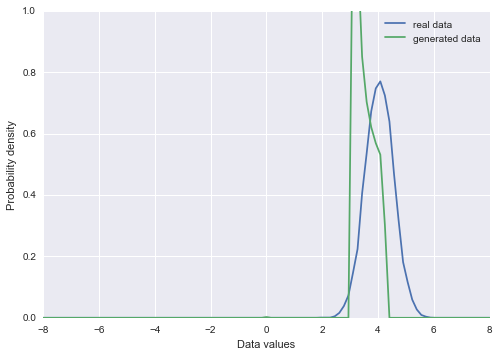

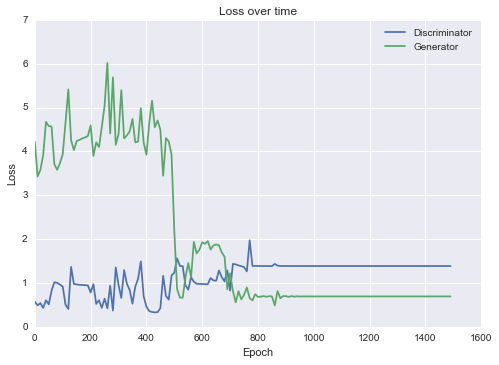

In [3]:
#set the random seed:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

#This specifies the actual data that the generator will be trying to mimic. 
class DataDistribution(object):
    def __init__(self):
        self.mu = 4       
        self.sigma = 0.5

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        num_steps = 1500,
        batch_size = 12,
        minibatch = False,
        log_every = 10,
        mlp_hidden_size = 4,
        anim_path = None )

model.train()


*number of epochs until stabilization: 900*

### Now with mini-batch used:

- Distribution: Normal 
- `mu` : 4
- `sigma` : 0.5
- Mini-batch? :  Used
- Number of hidden layers in the generator: 4   
  (discriminator has twice as many hidden layers)
- Random seed: 42

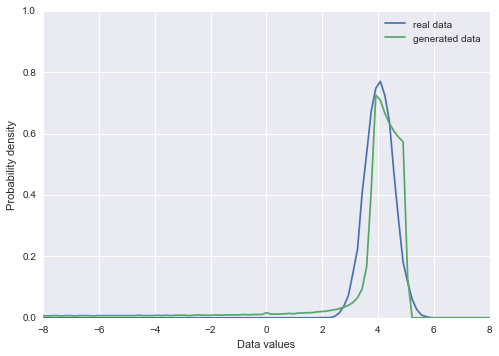

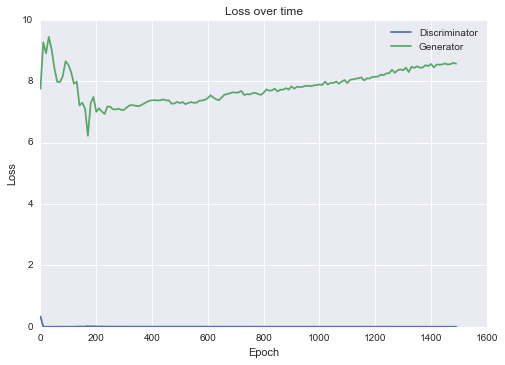

In [3]:
#set the random seed:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

#This specifies the actual data that the generator will be trying to mimic. 
class DataDistribution(object):
    def __init__(self):
        self.mu = 4       
        self.sigma = 0.5

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        num_steps = 1500,
        batch_size = 12,
        minibatch = True,
        log_every = 10,
        mlp_hidden_size = 4,
        anim_path = None )

model.train()

### Hidden layers  = 5

- Distribution: Normal 
- `mu` : 4
- `sigma` : 0.5
- Mini-batch? :  Not used
- Number of hidden layers in the generator:  6  
  (discriminator has twice as many hidden layers)
- Random seed: 42

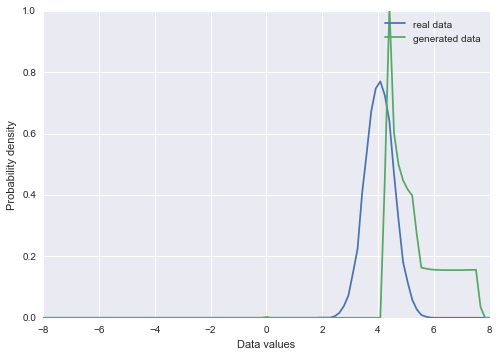

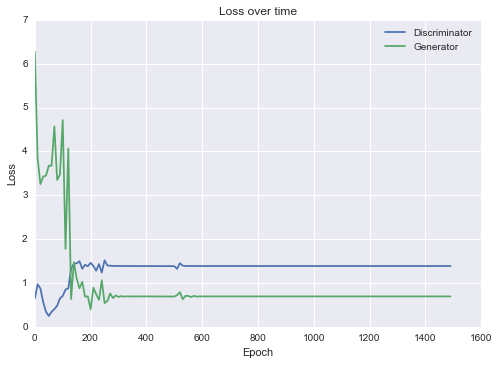

In [3]:
#set the random seed:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

#This specifies the actual data that the generator will be trying to mimic. 
class DataDistribution(object):
    def __init__(self):
        self.mu = 4       
        self.sigma = 0.5

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        num_steps = 1500,
        batch_size = 12,
        minibatch = False,
        log_every = 10,
        mlp_hidden_size = 5,
        anim_path = None )

model.train()

### Hidden layers  = 3

- Distribution: Normal 
- `mu` : 4
- `sigma` : 0.5
- Mini-batch? :  Not used
- Number of hidden layers in the generator:  6  
  (discriminator has twice as many hidden layers)
- Random seed: 55

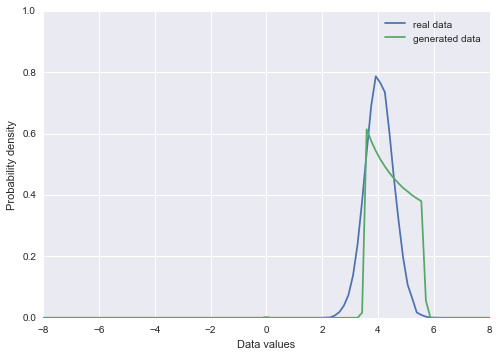

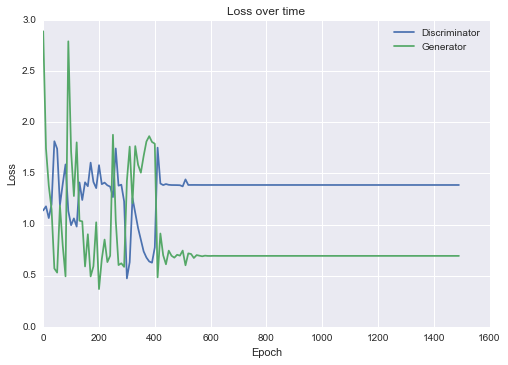

In [3]:
#set the random seed:
seed = 55
np.random.seed(seed)
tf.set_random_seed(seed)

#This specifies the actual data that the generator will be trying to mimic. 
class DataDistribution(object):
    def __init__(self):
        self.mu = 4       
        self.sigma = 0.5

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        num_steps = 1500,
        batch_size = 12,
        minibatch = False,
        log_every = 10,
        mlp_hidden_size = 3,
        anim_path = None )

model.train()

### Multimodal Distribution:
(Adam Optimizer)

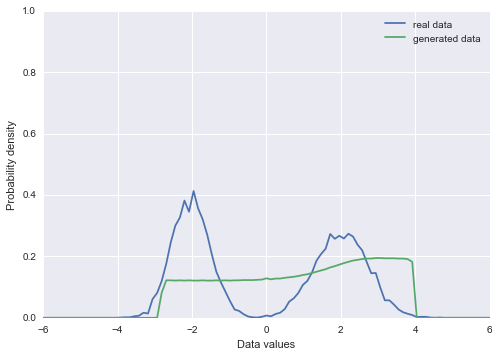

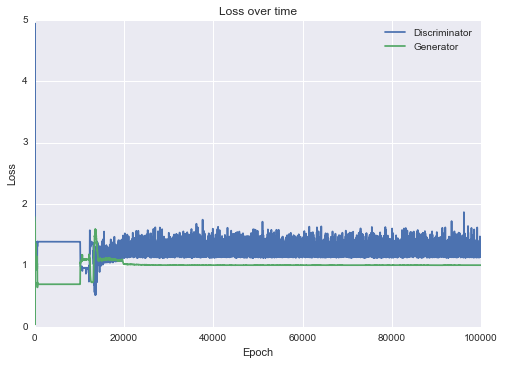

In [3]:
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)
 
class DataDistribution(object):
    def __init__(self):
        self.mu1 = -2               
        self.sigma1 = 0.5
        self.mu2 = 2
        self.sigma2 = 0.7
        N=12
        samples = np.concatenate((np.random.normal(self.mu1, self.sigma1, int(N/2)), np.random.normal(self.mu2, self.sigma2, int(N/2))), axis=0)
        self.mu = np.mean(samples)
        self.sigma = np.std(samples)

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.concatenate((np.random.normal(self.mu1, self.sigma1, int(N/2)), np.random.normal(self.mu2, self.sigma2, int(N/2))), axis=0)          
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=6),
        num_steps = 100000,
        batch_size = 12,
        minibatch = False,
        log_every = 10,
        mlp_hidden_size = 4,
        anim_path = None )

model.train()

### Multimodal Distribution:
(Gradient Descent Optimizer)

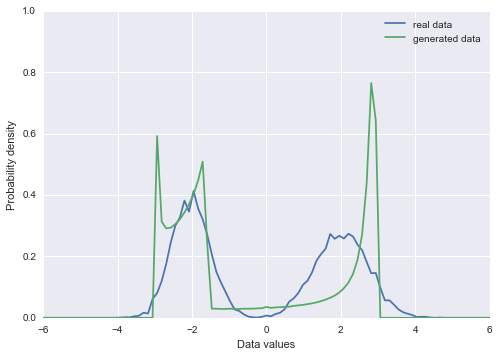

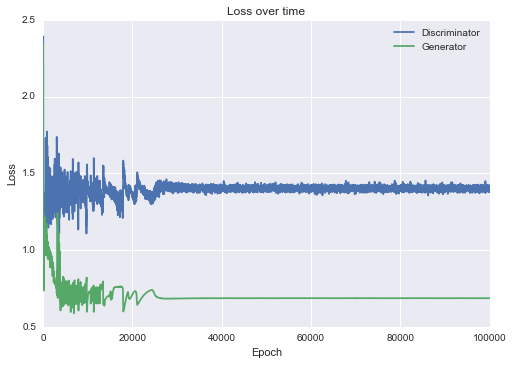

In [3]:
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)
 
class DataDistribution(object):
    def __init__(self):
        self.mu1 = -2               
        self.sigma1 = 0.5
        self.mu2 = 2
        self.sigma2 = 0.7
        N=12
        samples = np.concatenate((np.random.normal(self.mu1, self.sigma1, int(N/2)), np.random.normal(self.mu2, self.sigma2, int(N/2))), axis=0)
        self.mu = np.mean(samples)
        self.sigma = np.std(samples)

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.concatenate((np.random.normal(self.mu1, self.sigma1, int(N/2)), np.random.normal(self.mu2, self.sigma2, int(N/2))), axis=0)          
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=6),
        num_steps = 100000,
        batch_size = 12,
        minibatch = False,
        log_every = 10,
        mlp_hidden_size = 4,
        anim_path = None )

model.train()

### Varying Sigma:

- Distribution: Normal
- `mu`: 4
- `sigma`: __
- Mini-batch? :  Not used
- Number of hidden layers in the generator: 4   
  (discriminator has twice as many hidden layers)
- Random seed: 42

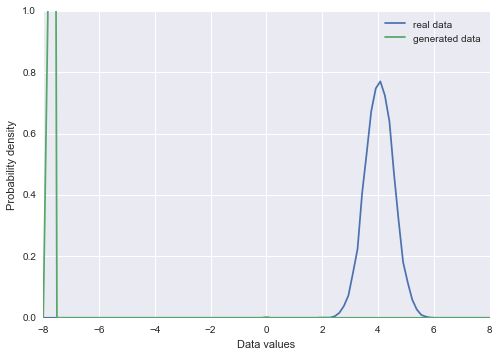

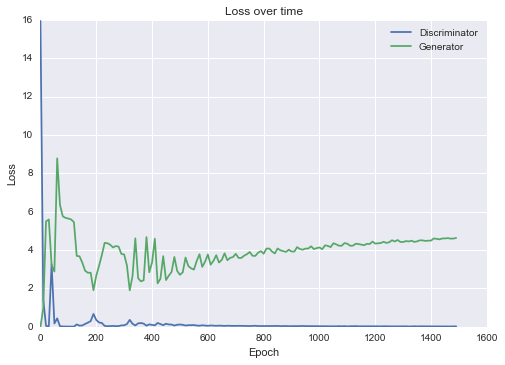

In [3]:
#set the random seed:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

#This specifies the actual data that the generator will be trying to mimic. 
class DataDistribution(object):
    def __init__(self):
        self.mu = 4       
        self.sigma = .5

    def sample(self, N):
        #generates N random samples from the normal distribution with the correct parameters
        #normal distribution can be changed to a different distribution
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        num_steps = 1500,
        batch_size = 12,
        minibatch = True,
        log_every = 10,
        mlp_hidden_size = 4,
        anim_path = None )

model.train()
